In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Data Science/HomeWork/Chuong5_DataPreprocessing"

/content/drive/MyDrive/Colab Notebooks/Data Science/HomeWork/Chuong5_DataPreprocessing


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from typing import List
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# 1. BT1
Viết chương trình đánh giá độ chính xác của thuật toán hồi quy logistic trong
bài toán dự báo Sự sống/chết (Survived) của hành khách lên tàu Titanic dựa
trên Độ tuổi (Age) và Giá vé (Fare) mà họ đã mua trong 14 tổ hợp làm sạch dữ
liệu sau:
- 7 kỹ thuật xử lý dữ liệu trống (Median/Mean/Mode imputation coi như 3 kỹ
thuật khác nhau, kỹ thuật tạo đặc trưng mới phải sử dụng đồng thời biến Age
và biến bổ sung Age_NAN để dự báo)
- 2 trường hợp Không xử lý ngoại lệ & Có xử lý ngoại lệ (đồng thời trên 2 biến
Age và Fare)
Lập bảng báo cáo độ chính xác của thuật toán trong 14 trường hợp trên và cho
biết độ chính xác cao nhất và thấp nhất xảy ra trong trường hợp nào. Phân tích
vì sao độ chính xác cao/thấp như vậy (Train/Test phân theo tỉ lệ 70/30 như
chương trình mẫu, mỗi trường hợp cần thử nghiệm 10 lần với random_state=0
đến 9 và lấy trung bình để được độ chính xác trung bình của thuật toán)

In [ ]:
# Doc file csv va chi dung 3 column: Survived, Age, Fare
df = pd.read_csv('titanic.csv', usecols=['Survived', 'Age', 'Fare', 'Sex'])
df.head(5)

,Survived,Sex,Age,Fare
0,0,male,22.0,7.2500
1,1,female,38.0,71.2833
2,1,female,26.0,7.9250
3,1,female,35.0,53.1000
4,0,male,35.0,8.0500


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   Fare      891 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 28.0+ KB


In [ ]:
# Ti le phan tram so luong row null cua cac columns
df.isnull().mean().sort_values(ascending=False)

Age         0.198653
Survived    0.000000
Sex         0.000000
Fare        0.000000
dtype: float64

In [ ]:
df['Survived'].sum() / len(df)

0.3838383838383838

### Transform Category to Ordinal

In [ ]:
class Transformer:
  @staticmethod
  def category_to_ordinal(df: pd.DataFrame, col: str, new_col: str):
    dt = df.copy()
    enc = OrdinalEncoder(dtype=np.int32)
    dt[new_col] = enc.fit_transform(dt[[col]])
    return dt
  
  @staticmethod
  def onehot(df: pd.DataFrame, col: str, new_col1: str, new_col2: str):
    dt = df.copy()
    enc = OneHotEncoder(sparse=False)
    dt[[new_col1, new_col2]] = enc.fit_transform(dt[[col]])
    return dt

In [ ]:
df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [ ]:
df = Transformer.onehot(df, 'Sex', 'Sex_transform1', 'Sex_transform2')
df

,Survived,Sex,Age,Fare,Sex_transform1,Sex_transform2
0,0,male,22.0,7.2500,0.0,1.0
1,1,female,38.0,71.2833,1.0,0.0
2,1,female,26.0,7.9250,1.0,0.0
3,1,female,35.0,53.1000,1.0,0.0
4,0,male,35.0,8.0500,0.0,1.0
...,...,...,...,...,...,...
886,0,male,27.0,13.0000,0.0,1.0
887,1,female,19.0,30.0000,1.0,0.0
888,0,female,NaN,23.4500,1.0,0.0
889,1,male,26.0,30.0000,0.0,1.0


## 1.1 Data with outlier

In [ ]:
class MissingHandler:
  @staticmethod
  def fill_nan_by_median(df: pd.DataFrame, col: str, new_col:str):
    dt = df.copy()
    median = dt[col].dropna().median()
    print(f"Median of {col} = {median}")

    dt[new_col] = dt[col]
    dt[new_col].fillna(median, inplace=True)
    return dt
  
  @staticmethod
  def fill_nan_by_mean(df: pd.DataFrame, col: str, new_col: str):
    dt = df.copy()
    mean = dt[col].dropna().mean()
    print(f"Mean of {col} = {mean}")

    dt[new_col] = dt[col]
    dt[new_col].fillna(mean, inplace=True)
    return dt

  @staticmethod
  def fill_nan_by_mode(df: pd.DataFrame, col: str, new_col: str):
    dt = df.copy()
    mode_age = dt.mode()[col].values[0]
    print(f"Mode of {col} = {mode_age}")

    dt[new_col] = dt[col]
    dt[new_col].fillna(mode_age, inplace=True)
    return dt

  @staticmethod
  def fill_nan_by_end_distribution(df: pd.DataFrame, col: str, new_col: str):
    dt = df.copy()
    extreme = dt[col].mean() + 3 * dt[col].std()
    print(f'End of distribution of {col}: {extreme}')

    dt[new_col] = dt[col].fillna(extreme)
    return dt

  @staticmethod
  def fill_nan_by_random(df: pd.DataFrame, col: str, new_col: str):
    dt = df.copy()
    number_null_row = dt[col].isnull().sum()
    random_samples = dt[col].dropna().sample(n=number_null_row, random_state=0)

    dt[new_col] = dt[col]
    random_samples.index = dt[dt[col].isnull()].index
    dt.loc[dt[col].isnull(), new_col] = random_samples
    return dt

  @staticmethod
  def fill_nan_by_arbitrary(df: pd.DataFrame, col: str, new_col: str, start: int, end: int):
    dt = df.copy()
    dt[new_col] = dt[col].fillna(np.random.randint(start, end))
    return dt

In [ ]:
# Tao column Age_NAN
df['Age_NAN'] = np.where(df['Age'].isnull(), 1, 0)

df[['Age', 'Age_NAN']].tail()

,Age,Age_NAN
886,27.0,0
887,19.0,0
888,NaN,1
889,26.0,0
890,32.0,0


In [ ]:
df = MissingHandler.fill_nan_by_median(df, 'Age', 'Age_median')
df[['Age', 'Age_median']].head(6)

Median of Age = 28.0


,Age,Age_median
0,22.0,22.0
1,38.0,38.0
2,26.0,26.0
3,35.0,35.0
4,35.0,35.0
5,NaN,28.0


In [ ]:
# Tao column Age_mean
df = MissingHandler.fill_nan_by_mean(df, 'Age', 'Age_mean')
df[['Age', 'Age_mean']].head(6)

Mean of Age = 29.69911764705882


,Age,Age_mean
0,22.0,22.000000
1,38.0,38.000000
2,26.0,26.000000
3,35.0,35.000000
4,35.0,35.000000
5,NaN,29.699118


In [ ]:
# Tao column Age_mode
df = MissingHandler.fill_nan_by_mode(df, 'Age', 'Age_mode')
df[['Age', 'Age_mode']].head(6)

Mode of Age = 24.0


,Age,Age_mode
0,22.0,22.0
1,38.0,38.0
2,26.0,26.0
3,35.0,35.0
4,35.0,35.0
5,NaN,24.0


In [ ]:
# Tao column Age_end_dist (thay the gia tri null bang duoi cua phan bo)
df = MissingHandler.fill_nan_by_end_distribution(df, 'Age', 'Age_end_dist')
df[['Age', 'Age_end_dist']].head(6)

End of distribution of Age: 73.27860964406095


,Age,Age_end_dist
0,22.0,22.00000
1,38.0,38.00000
2,26.0,26.00000
3,35.0,35.00000
4,35.0,35.00000
5,NaN,73.27861


In [ ]:
# Tao colum Age_random (thay the gia tri null bang gia tri ngau nhien)
df = MissingHandler.fill_nan_by_random(df, 'Age', 'Age_random')
df[['Age', 'Age_random']].head(6)

,Age,Age_random
0,22.0,22.0
1,38.0,38.0
2,26.0,26.0
3,35.0,35.0
4,35.0,35.0
5,NaN,28.0


In [ ]:
# Tao column Age_arbitrary (Thay the gia tri null bang gia tri bat ki)
# Nguoi co so tuoi cao nhat the gioi la 127 tuoi (nguoi Nhat ban)
df = MissingHandler.fill_nan_by_arbitrary(df, 'Age', 'Age_arbitrary', start=0, end=127)
df[['Age', 'Age_arbitrary']].head(6)

,Age,Age_arbitrary
0,22.0,22.0
1,38.0,38.0
2,26.0,26.0
3,35.0,35.0
4,35.0,35.0
5,NaN,75.0


In [ ]:
print(f"Std of Age = {df['Age'].std()}")
print(f"Std of Age_median = {df['Age_median'].std()}")
print(f"Std of Age_mean = {df['Age_mean'].std()}")
print(f"Std of Age_mode = {df['Age_mode'].std()}")
print(f"Std of Age_end_dist = {df['Age_end_dist'].std()}")
print(f"Std of Age_random = {df['Age_random'].std()}")
print(f"Std of Age_arbitrary = {df['Age_arbitrary'].std()}")

Std of Age = 14.526497332334044
Std of Age_median = 13.019696550973194
Std of Age_mean = 13.002015226002884
Std of Age_mode = 13.199571767746487
Std of Age_end_dist = 21.719150677136366
Std of Age_random = 14.5636540895687
Std of Age_arbitrary = 22.273405915866398


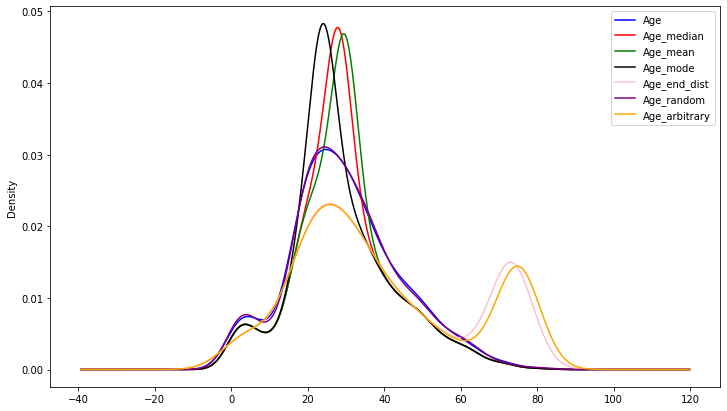

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
df['Age'].plot(kind='kde', color='blue')
df['Age_median'].plot(kind='kde', color='red')
df['Age_mean'].plot(kind='kde', color='green')
df['Age_mode'].plot(kind='kde', color='black')
df['Age_end_dist'].plot(kind='kde', color='pink')
df['Age_random'].plot(kind='kde', color='purple')
df['Age_arbitrary'].plot(kind='kde', color='orange')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

### Code dự đoán với trường hợp KHÔNG xử lí ngoại lệ

In [ ]:
class Trainer:
  @staticmethod
  def train(df: pd.DataFrame, list_feature_need_train: List[str], target_feature: str, additional_source_feature: List[str]):
    dt = df.copy()
    scores = dict()
    store = dict()

    for label in list_feature_need_train:
      # split "Age_mean+AgeNAN" ==> ['Age_mean', 'AgeNAN']
      features = label.split("+")
      for random_state in range(0, 10):
        x_train, x_test, y_train, y_test = train_test_split(dt[[*features, *additional_source_feature]], dt[target_feature], test_size=0.3, random_state=random_state)
        logisticRegr = LogisticRegression(random_state=random_state).fit(x_train, y_train)

        score = logisticRegr.score(x_test, y_test)
        if label not in scores:
          scores[label] = []
        scores[label].append(score)
        # print(f'Run #{random_state}: {score}')

      mean_score = np.array(scores[label]).mean()
      store.update({label: mean_score})
      print(f'[{label}] Score = {mean_score}')
    
    return store
  
  @staticmethod
  def train_cross_val(df: pd.DataFrame, list_feature_need_train: List[str], target_feature: str, additional_source_feature: List[str]):
    dt = df.copy()
    clf = LogisticRegression(random_state=0)
    store = dict()

    for label in list_feature_need_train:
      # split "Age_mean+AgeNAN" ==> ['Age_mean', 'AgeNAN']
      features = label.split("+")
      X = dt[[*features, *additional_source_feature]]
      y = dt[target_feature]
      scores = cross_val_score(clf, X, y, cv=5)

      mean_score = scores.mean()
      store.update({label: mean_score})
      print(f'[{label}] Score = {mean_score}')
    
    return store

In [ ]:
features_need_run = ['Age_median', 'Age_mean', 'Age_mode', 'Age_end_dist', 'Age_random', 'Age_arbitrary', 'Age_mean+Age_NAN']
store = Trainer.train_cross_val(df, features_need_run, 'Survived', ['Fare', 'Sex_transform1', 'Sex_transform2'])

[Age_median] Score = 0.7822547234950725
[Age_mean] Score = 0.7822547234950725
[Age_mode] Score = 0.7822547234950725
[Age_end_dist] Score = 0.7822547234950725
[Age_random] Score = 0.7811311279894545
[Age_arbitrary] Score = 0.7833783190006904
[Age_mean+Age_NAN] Score = 0.7822547234950725


## 1.2 Data without outliers

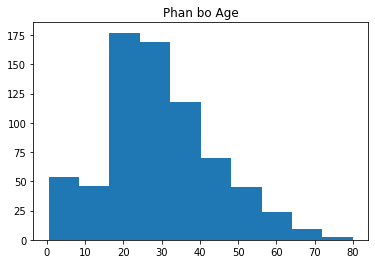

In [ ]:
# Phan bo Age feature
plt.hist(df['Age'].dropna())
plt.title('Phan bo Age')
plt.show()

In [ ]:
# Do du lieu phan bo lech trai (skewed), nen su dung IQR de tim kiem bien tren, bien duoi
q3, q1 = np.percentile(df['Age'].dropna(), [75, 25])
iqr = q3 - q1
upper_bound = q3 + 1 * iqr
lower_bound = q1 - 1 * iqr

print(f'q3 = {q3}, q1 = {q1}, iqr = {iqr}') 
print(f'lower_bound = {lower_bound}, upper_bound = {upper_bound}')

q3 = 38.0, q1 = 20.125, iqr = 17.875
lower_bound = 2.25, upper_bound = 55.875


In [ ]:
# Xu li gia tri ngoai le
df['Age_without_outlier'] = df['Age']
df['Age_without_outlier'].values[df['Age_without_outlier'].values > upper_bound] = upper_bound
df['Age_without_outlier'].values[df['Age_without_outlier'].values < lower_bound] = lower_bound

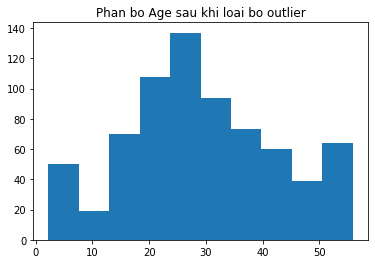

In [ ]:
# Phan bo Age feature sau khi loai bo outlier
plt.hist(df['Age_without_outlier'].dropna())
plt.title('Phan bo Age sau khi loai bo outlier')
plt.show()

In [ ]:
df['Age_NAN/without_outlier'] = np.where(df['Age_without_outlier'].isnull(), 1, 0)
df = MissingHandler.fill_nan_by_median(df, 'Age_without_outlier', 'Age_median/without_outlier')
df = MissingHandler.fill_nan_by_mean(df, 'Age_without_outlier', 'Age_mean/without_outlier')
df = MissingHandler.fill_nan_by_mode(df, 'Age_without_outlier', 'Age_mode/without_outlier')
df = MissingHandler.fill_nan_by_end_distribution(df, 'Age_without_outlier', 'Age_end_dist/without_outlier')
df = MissingHandler.fill_nan_by_random(df, 'Age_without_outlier', 'Age_random/without_outlier')
df = MissingHandler.fill_nan_by_arbitrary(df, 'Age_without_outlier', 'Age_arbitrary/without_outlier', start=0, end=127)

Median of Age_without_outlier = 28.0
Mean of Age_without_outlier = 29.36642156862745
Mode of Age_without_outlier = 55.875
End of distribution of Age_without_outlier: 70.28809955593991


In [ ]:
print(f"Std of Age_without_outlier = {df['Age_without_outlier'].std()}")
print(f"Std of Age_median/without_outlier = {df['Age_median/without_outlier'].std()}")
print(f"Std of Age_mean/without_outlier = {df['Age_mean/without_outlier'].std()}")
print(f"Std of Age_mode/without_outlier = {df['Age_mode/without_outlier'].std()}")
print(f"Std of Age_end_dist/without_outlier = {df['Age_end_dist/without_outlier'].std()}")
print(f"Std of Age_random/without_outlier = {df['Age_random/without_outlier'].std()}")
print(f"Std of Age_arbitrary/without_outlier = {df['Age_arbitrary/without_outlier'].std()}")

Std of Age_without_outlier = 13.640559329104155
Std of Age_median/without_outlier = 12.221231842670573
Std of Age_mean/without_outlier = 12.209051916007308
Std of Age_mode/without_outlier = 16.15705041828937
Std of Age_end_dist/without_outlier = 20.39454912023378
Std of Age_random/without_outlier = 13.648780539673844
Std of Age_arbitrary/without_outlier = 19.670476476583406


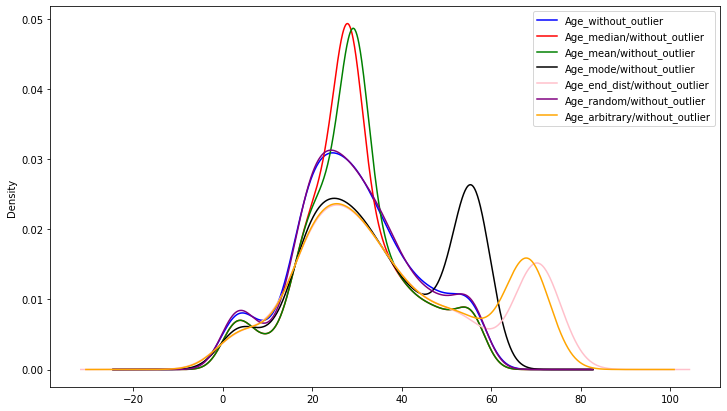

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
df['Age_without_outlier'].plot(kind='kde', color='blue')
df['Age_median/without_outlier'].plot(kind='kde', color='red')
df['Age_mean/without_outlier'].plot(kind='kde', color='green')
df['Age_mode/without_outlier'].plot(kind='kde', color='black')
df['Age_end_dist/without_outlier'].plot(kind='kde', color='pink')
df['Age_random/without_outlier'].plot(kind='kde', color='purple')
df['Age_arbitrary/without_outlier'].plot(kind='kde', color='orange')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

### Code dự đoán với trường hợp có xử lí ngoại lệ

In [ ]:
features_need_run = ['Age_median/without_outlier', 'Age_mean/without_outlier', 'Age_mode/without_outlier', 'Age_end_dist/without_outlier', 
                     'Age_random/without_outlier', 'Age_arbitrary/without_outlier', 'Age_mean/without_outlier+Age_NAN/without_outlier']
store_without_outlier = Trainer.train_cross_val(df, features_need_run, 'Survived', ['Fare', 'Sex_transform'])

[Age_median/without_outlier] Score = 0.7822547234950725
[Age_mean/without_outlier] Score = 0.7822547234950725
[Age_mode/without_outlier] Score = 0.7822547234950725
[Age_end_dist/without_outlier] Score = 0.7822547234950725
[Age_random/without_outlier] Score = 0.7811311279894545
[Age_arbitrary/without_outlier] Score = 0.7766744083861653
[Age_mean/without_outlier+Age_NAN/without_outlier] Score = 0.7822547234950725


In [ ]:
features_need_run = ['Age_median/without_outlier', 'Age_mean/without_outlier', 'Age_mode/without_outlier', 'Age_end_dist/without_outlier', 
                     'Age_random/without_outlier', 'Age_arbitrary/without_outlier', 'Age_mean/without_outlier+Age_NAN/without_outlier']
store_without_outlier = Trainer.train_cross_val(df, features_need_run, 'Survived', ['Fare', 'Sex_transform1', 'Sex_transform2'])

[Age_median/without_outlier] Score = 0.7822547234950725
[Age_mean/without_outlier] Score = 0.7822547234950725
[Age_mode/without_outlier] Score = 0.7822547234950725
[Age_end_dist/without_outlier] Score = 0.7822547234950725
[Age_random/without_outlier] Score = 0.7811311279894545
[Age_arbitrary/without_outlier] Score = 0.7822547234950725
[Age_mean/without_outlier+Age_NAN/without_outlier] Score = 0.7822547234950725


## 1.3 Conclusion

In [ ]:
store_result = dict()
for key, val in store.items():
  store_result[key] = round(val * 100, 2)

for key, val in store_without_outlier.items():
  store_result[key] = round(val * 100, 2)

In [ ]:
data = [
        [store_result['Age_median'], store_result['Age_median/without_outlier']],
        [store_result['Age_mean'], store_result['Age_mean/without_outlier']],
        [store_result['Age_mode'], store_result['Age_mode/without_outlier']],
        [store_result['Age_random'], store_result['Age_random/without_outlier']],
        [store_result['Age_end_dist'], store_result['Age_end_dist/without_outlier']],
        [store_result['Age_arbitrary'], store_result['Age_arbitrary/without_outlier']],
        [store_result['Age_mean+Age_NAN'], store_result['Age_mean/without_outlier+Age_NAN/without_outlier']],
      ]

pd.DataFrame(data=data, columns=['Outlier', 'Without Outlier'], index=['median', 'mean', 'mode', 'random', 'end_dist', 'arbitrary', 'mean+NAN'])

,Outlier,Without Outlier
median,78.23,78.23
mean,78.23,78.23
mode,78.23,78.23
random,78.11,78.11
end_dist,78.23,78.23
arbitrary,78.23,77.67
mean+NAN,78.23,78.23


In [ ]:
store_result = dict()
for key, val in store.items():
  store_result[key] = round(val * 100, 2)

for key, val in store_without_outlier.items():
  store_result[key] = round(val * 100, 2)
  
data = [
        [store_result['Age_median'], store_result['Age_median/without_outlier']],
        [store_result['Age_mean'], store_result['Age_mean/without_outlier']],
        [store_result['Age_mode'], store_result['Age_mode/without_outlier']],
        [store_result['Age_random'], store_result['Age_random/without_outlier']],
        [store_result['Age_end_dist'], store_result['Age_end_dist/without_outlier']],
        [store_result['Age_arbitrary'], store_result['Age_arbitrary/without_outlier']],
        [store_result['Age_mean+Age_NAN'], store_result['Age_mean/without_outlier+Age_NAN/without_outlier']],
      ]

pd.DataFrame(data=data, columns=['Outlier', 'Without Outlier'], index=['median', 'mean', 'mode', 'random', 'end_dist', 'arbitrary', 'mean+NAN'])

,Outlier,Without Outlier
median,78.23,78.23
mean,78.23,78.23
mode,78.23,78.23
random,78.11,78.11
end_dist,78.23,78.23
arbitrary,78.34,78.23
mean+NAN,78.23,78.23


Nhận xét:
- Việc xử lí ngoại lệ giúp tăng độ chính xác trong một số phương pháp làm sạch dữ liệu như: arbitrary, mode, thêm feature mới (mean+NAN).
- Tuy nhiên, vẫn có một số trường hợp bị giảm độ chính xác khi làm sạch tầm 0.05% như median, mean.

# BT2
- Đề xuất các kỹ thuật chuẩn hoá dữ liệu phù hợp để cải thiện độ chính xác
của thuật toán hồi quy logistic trong bài toán dự báo Sự sống/chết (Survived)
của hành khách lên tàu Titanic dựa trên Độ tuổi (Age) và Giá vé (Fare) mà họ
đã mua.
- Cho biết độ cải thiện (%) về độ chính xác dự báo khi áp dụng kỹ thuật chuẩn
hoá dữ liệu đã đề xuất kết hợp với 1 trong 14 tổ hợp kỹ thuật làm sạch dữ
liệu của Bài tập Phần 5.1

## Chuẩn hóa min-max, áp dụng vào làm sạch bằng median và có xử lí ngọai lệ

In [ ]:
# Chuan hoa min-max cho feature Age_median/without_outlier va Fare
df_scaled = MinMaxScaler()
df_scaled = pd.DataFrame(df_scaled.fit_transform(df[['Age_median/without_outlier', 'Fare', 'Sex_transform']]),columns=['Age_median/without_outlier', 'Fare', 'Sex_transform'])
df_scaled['Survived'] = df['Survived']
df_scaled.head()

,Age_median/without_outlier,Fare,Sex_transform,Survived
0,0.368298,0.014151,1.0,0
1,0.666667,0.139136,0.0,1
2,0.442890,0.015469,0.0,1
3,0.610723,0.103644,0.0,1
4,0.610723,0.015713,1.0,0


Text(0.5, 1.0, 'Sau normalize')

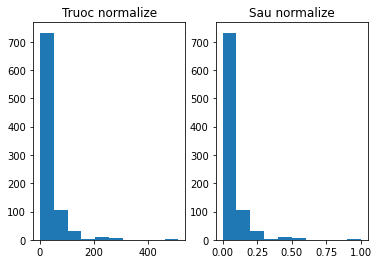

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(df['Fare'])
ax[1].hist(df_scaled['Fare'])
ax[0].set_title('Truoc normalize')
ax[1].set_title('Sau normalize')

Text(0.5, 1.0, 'Sau normalize')

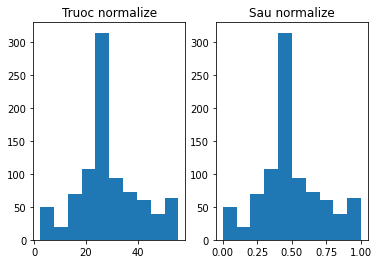

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(df['Age_median/without_outlier'])
ax[1].hist(df_scaled['Age_median/without_outlier'])
ax[0].set_title('Truoc normalize')
ax[1].set_title('Sau normalize')

In [ ]:
features_need_run = ['Age_median/without_outlier']
store_without_outlier = Trainer.train_cross_val(df_scaled, features_need_run, 'Survived', ['Fare', 'Sex_transform'])


[Age_median/without_outlier] Score = 0.7878664239532986


* Độ chính xác trước khi normalize là: 77.23%
* Độ chính xác sau khi normalize là: 77.79% \

## Chuẩn hóa z-score, áp dụng vào làm sạch bằng median và có xử lí ngọai lệ

In [ ]:
# Chuan hoa z-score
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['Age_median/without_outlier', 'Fare', 'Sex_transform']]),columns=['Age_median/without_outlier', 'Fare', 'Sex_transform'])

df_scaled['Survived'] = df['Survived']

features_need_run = ['Age_median/without_outlier']
store_without_outlier = Trainer.train_cross_val(df_scaled, features_need_run, 'Survived', ['Fare', 'Sex_transform'])

[Age_median/without_outlier] Score = 0.7822547234950725


* Độ chính xác trước khi normalize là: 78.23%
* Độ chính xác sau khi normalize là: 78.23% \

## Chuẩn hóa mạnh với ngoại lệ (robust), áp dụng vào làm sạch bằng median và có xử lí ngọai lệ

In [ ]:
# Chuan hoa robust
scaler = RobustScaler()
df_robust_scaler = pd.DataFrame(scaler.fit_transform(df[['Age_median/without_outlier', 'Fare', 'Sex_transform']]),columns=['Age_median/without_outlier', 'Fare', 'Sex_transform'])

df_robust_scaler['Survived'] = df['Survived']

features_need_run = ['Age_median/without_outlier']
store_without_outlier = Trainer.train_cross_val(df_scaled, features_need_run, 'Survived', ['Fare', 'Sex_transform'])

[Age_median/without_outlier] Score = 0.7822547234950725


* Độ chính xác trước khi normalize là: 78.23%
* Độ chính xác sau khi normalize là: 78.23% \

## Grid Search


In [ ]:
parameters = {
    "solver": ['liblinear', 'newton-cg', 'lbfgs'],
    "max_iter": [500, 20000],
    "C": [1e-1, 0.5, 1, 3, 5, 10]
}
model = LogisticRegression()
clf = GridSearchCV(model, parameters, scoring="accuracy")
clf.fit(df[["Fare", "Age_median/without_outlier", "Sex_transform"]].to_numpy(), df["Survived"].to_numpy())

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.5, 1, 3, 5, 10], 'max_iter': [500, 20000],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs']},
             scoring='accuracy')

In [ ]:
pd.DataFrame(clf.cv_results_)[["mean_score_time", "params", "mean_test_score", "rank_test_score"]]

,mean_score_time,params,mean_test_score,rank_test_score
0,0.000429,"{'C': 0.1, 'max_iter': 500, 'solver': 'libline...",0.780008,31
1,0.000439,"{'C': 0.1, 'max_iter': 500, 'solver': 'newton-...",0.777760,33
2,0.000479,"{'C': 0.1, 'max_iter': 500, 'solver': 'lbfgs'}",0.777760,33
3,0.000424,"{'C': 0.1, 'max_iter': 20000, 'solver': 'libli...",0.780008,31
4,0.000433,"{'C': 0.1, 'max_iter': 20000, 'solver': 'newto...",0.777760,33
5,0.000467,"{'C': 0.1, 'max_iter': 20000, 'solver': 'lbfgs'}",0.777760,33
6,0.000371,"{'C': 0.5, 'max_iter': 500, 'solver': 'libline...",0.782255,1
7,0.000463,"{'C': 0.5, 'max_iter': 500, 'solver': 'newton-...",0.782255,1
8,0.000440,"{'C': 0.5, 'max_iter': 500, 'solver': 'lbfgs'}",0.782255,1
9,0.000378,"{'C': 0.5, 'max_iter': 20000, 'solver': 'libli...",0.782255,1


Có rất nhiều bộ tham số tối ưu (rank = 1), chọn 1 trong số đó và kiểm tra độ chính xác mới

In [ ]:
score = cross_val_score(LogisticRegression(C=3, solver="lbfgs"), df[["Fare", "Age_median/without_outlier", "Sex_transform"]], df["Survived"], cv=5)
score.mean()

0.7822547234950725